In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path

In [7]:
import os

# make sure the current working directory is the root of the project (MSNE-NISE-23)
wd = Path(os.getcwd())
if wd.name == "notebooks":
    os.chdir(wd.parent)

In [8]:
# Load the datasets
folder = Path("data/recordings_labeled/2023-11-15_21-15-09/")
data_file_path = folder / "data.csv"
labels_file_path = folder / "labels.csv"
folder.exists(), data_file_path.exists(), labels_file_path.exists()

(True, True, True)

In [9]:
# Read the CSV files
data_df = pd.read_csv(data_file_path)
labels_df = pd.read_csv(labels_file_path)

# Truncate the data signal to match the label signal timeframe
last_label_timestamp = labels_df["timestamp"].iloc[-1]
truncated_data_df = data_df[data_df["timestamp"] <= last_label_timestamp]

# Resample label signal to match data signal timestamps
data_timestamps = truncated_data_df["timestamp"]
label_timestamps = labels_df["timestamp"]

# Interpolation functions for each label
interp_label_left = interp1d(
    label_timestamps,
    labels_df["label_left"],
    bounds_error=False,
    fill_value="extrapolate",
)
interp_label_right = interp1d(
    label_timestamps,
    labels_df["label_right"],
    bounds_error=False,
    fill_value="extrapolate",
)

# Apply interpolation
aligned_label_left = interp_label_left(data_timestamps)
aligned_label_right = interp_label_right(data_timestamps)

# Create DataFrame for aligned labels
aligned_labels_df = pd.DataFrame(
    {
        "timestamp": data_timestamps,
        "label_left": aligned_label_left,
        "label_right": aligned_label_right,
    }
)

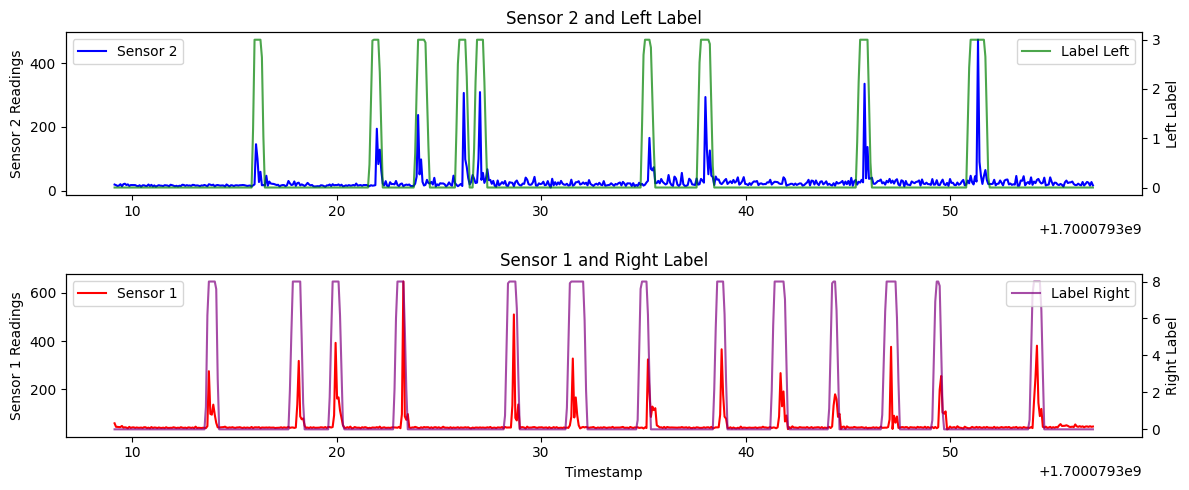

In [13]:
# Creating plots with overlay of sensor data and corresponding labels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))

# Sensor 2 and Left Label
ax1a = ax1.twinx()  # Create a second y-axis for the label
ax1.plot(
    truncated_data_df["timestamp"],
    truncated_data_df["sensor_2"],
    color="blue",
    label="Sensor 2",
)
ax1a.plot(
    aligned_labels_df["timestamp"],
    aligned_labels_df["label_left"],
    color="green",
    label="Label Left",
    alpha=0.7,
)

# Sensor 1 and Right Label
ax2a = ax2.twinx()  # Create a second y-axis for the label
ax2.plot(
    truncated_data_df["timestamp"],
    truncated_data_df["sensor_1"],
    color="red",
    label="Sensor 1",
)
ax2a.plot(
    aligned_labels_df["timestamp"],
    aligned_labels_df["label_right"],
    color="purple",
    label="Label Right",
    alpha=0.7,
)

# Setting titles and labels
ax1.set_title("Sensor 2 and Left Label")
ax1.set_ylabel("Sensor 2 Readings")
ax1a.set_ylabel("Left Label")

ax2.set_title("Sensor 1 and Right Label")
ax2.set_ylabel("Sensor 1 Readings")
ax2a.set_ylabel("Right Label")
ax2.set_xlabel("Timestamp")

# Adding legends
ax1.legend(loc="upper left")
ax1a.legend(loc="upper right")
ax2.legend(loc="upper left")
ax2a.legend(loc="upper right")

plt.tight_layout()
plt.show()

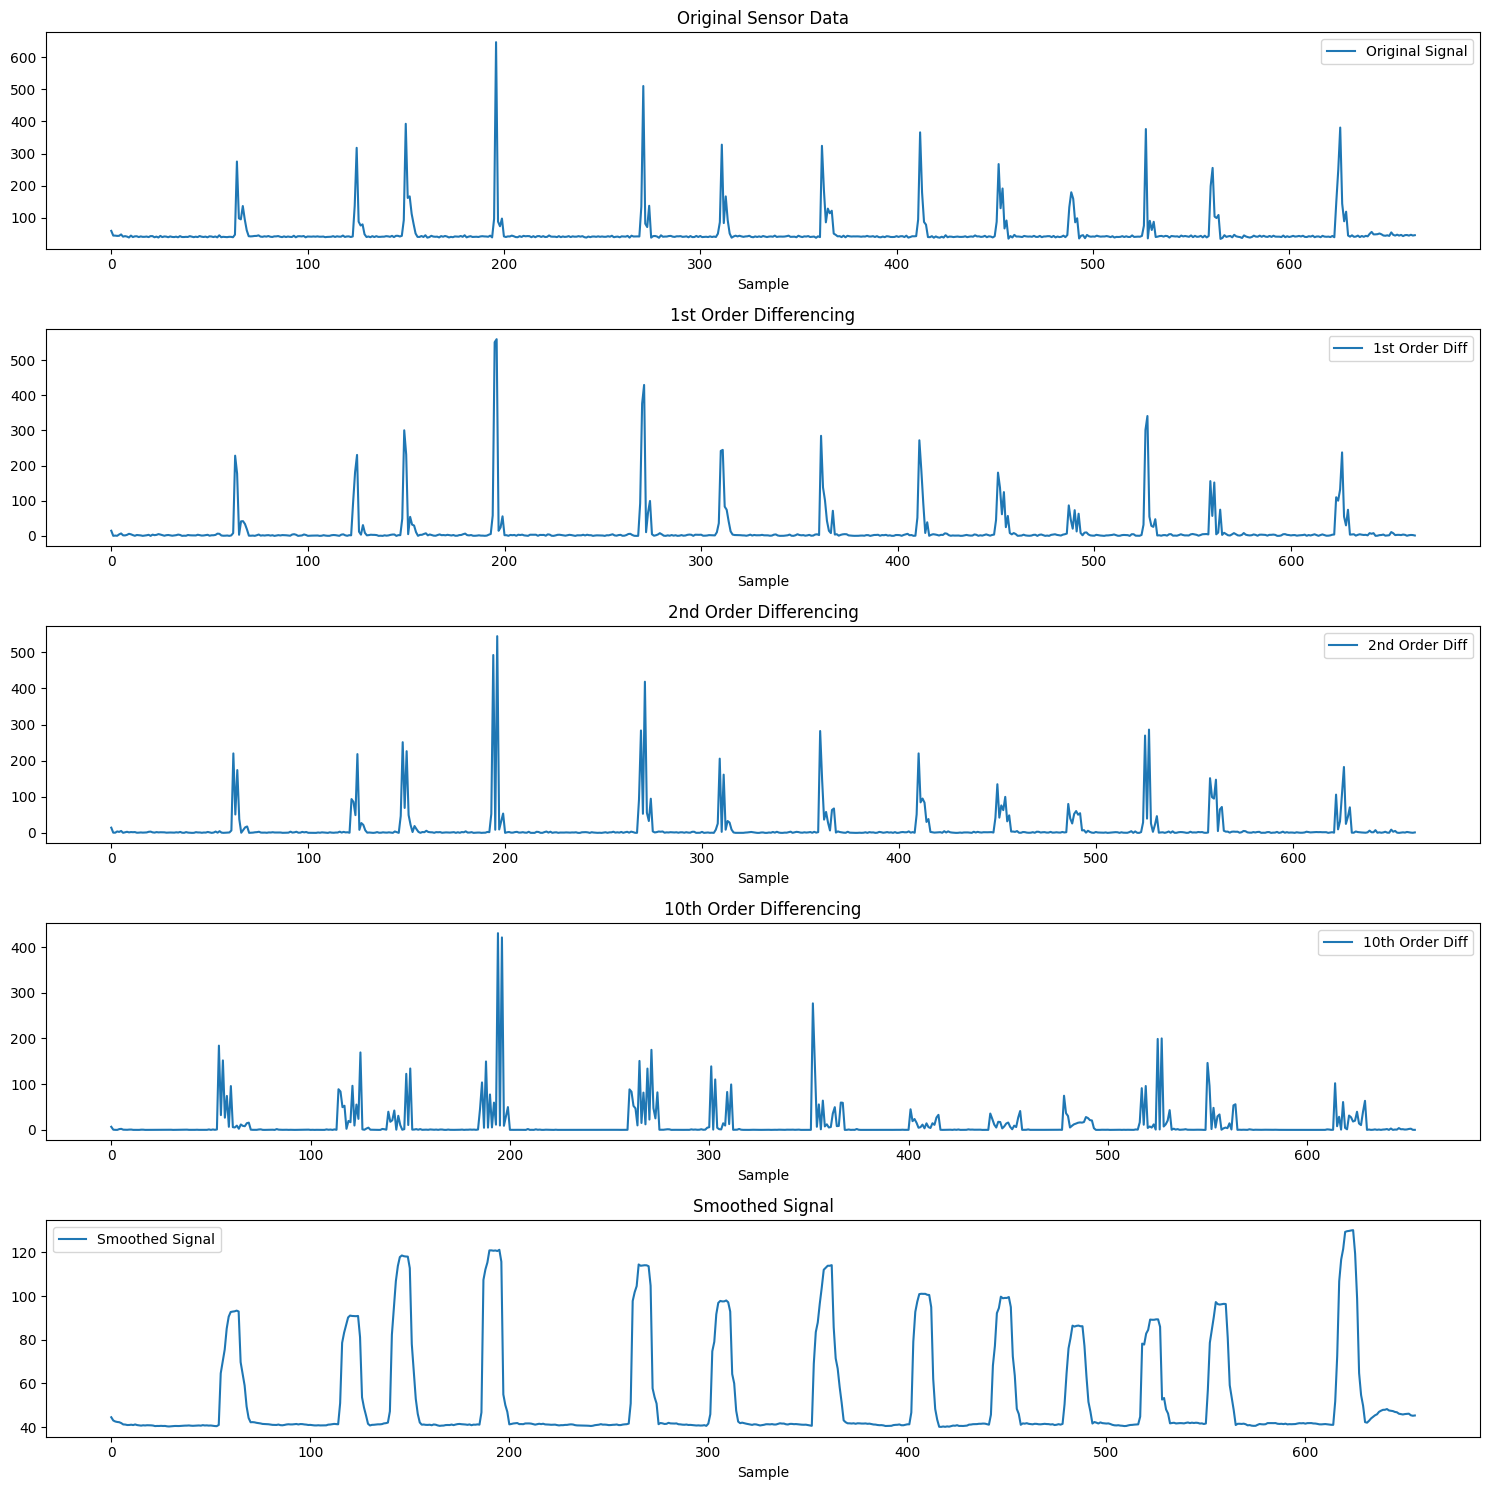

In [19]:
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, freqz, sosfilt, sosfreqz, iirnotch

# Assuming a sampling rate (in Hz) if not specified
sampling_rate = 1000  # Example value, needs to be adjusted according to the actual data


# Function to apply a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="band", output="sos")
    return sos


# Function to apply the bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y


# Function to apply a notch filter
def apply_notch_filter(data, notch_freq, fs, quality=30):
    nyq = 0.5 * fs
    freq = notch_freq / nyq
    b, a = iirnotch(freq, quality)
    y = filtfilt(b, a, data)
    return y


# Parameters for filters (example values, can be adjusted)
lowcut = 20.0
highcut = 450.0
notch_freq = 50.0  # Assuming power line frequency of 50 Hz

# Preprocessing steps
sensor_data = truncated_data_df["sensor_1"]


def abs_diff(x, n=1):
    diff_x = np.abs(np.diff(x, n=1))
    if n == 1:
        return diff_x
    elif n > 1:
        return abs_diff(diff_x, n=n - 1)
    else:
        raise ValueError("n must be a positive integer")


# Applying differencing
diff_order_1 = abs_diff(sensor_data, n=1)
diff_order_2 = abs_diff(sensor_data, n=2)
diff_order_10 = abs_diff(sensor_data, n=10)


# Smoothing (simple moving average)
window_size = 10  # Example window size
smoothed_signal = np.convolve(
    sensor_data, np.ones(window_size) / window_size, mode="valid"
)

# Applying notch filter
notch_filtered_signal = apply_notch_filter(sensor_data, notch_freq, sampling_rate)

# Applying bandpass filter
bandpass_filtered_signal = butter_bandpass_filter(
    sensor_data, lowcut, highcut, sampling_rate, order=4
)

# Plotting the results
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
axes[0].plot(sensor_data, label="Original Signal")
axes[0].set_title("Original Sensor Data")
axes[1].plot(diff_order_1, label="1st Order Diff")
axes[1].set_title("1st Order Differencing")
axes[2].plot(diff_order_2, label="2nd Order Diff")
axes[2].set_title("2nd Order Differencing")
axes[3].plot(diff_order_10, label="10th Order Diff")
axes[3].set_title("10th Order Differencing")
axes[4].plot(smoothed_signal, label="Smoothed Signal")
axes[4].set_title("Smoothed Signal")

for ax in axes:
    ax.legend()
    ax.set_xlabel("Sample")

plt.tight_layout()
plt.show()